## Questrion 6.3

In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import ArrayLike
import os
import pathlib
from scipy import fftpack
from sklearn.utils import shuffle
import sys
import torch
from torch import nn
# from torch import distributions
import torch.distributions as td
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from tqdm import tqdm
from typing import Callable

curr_dir = pathlib.Path(os.getcwd())
prj_dir = curr_dir.parent.parent
figs_dir = curr_dir / "figs"
sys.path.insert(0, str(prj_dir))
from grf_lab.models.kmod import cosmos

from grf_lab.models import RealNVP
from grf_lab.models import AutoEncoderA, AutoEncoderC, AutoEncoderA2, AutoencoderA3, AutoEncoderB

data_dir = curr_dir / "data"
figs_dir = curr_dir / "figs/grfs/" # Change this to your specification


for _path in [data_dir, figs_dir]:
    if not _path.exists():
        os.makedirs(_path, exist_ok=True)

SEED = 42
rng = np.random.default_rng(seed=SEED)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
def convert(x):
    # Convert a numpy array to a torch tensor with float32 entries
    return torch.as_tensor(x).float()

device

device(type='cuda')

### Syb-question 1

Fit the autoencoder and write a validation loop for its training.

In [3]:
"""
    Fit NVP flow to GRFs at the field level (likelihood).
"""
def get_dataloader_from_arrays(data, targets, batch_size):

    class TensorDataset(Dataset):
        def __init__(self, data, targets):
            self.data = torch.as_tensor(data).float()
            self.labels = torch.as_tensor(targets).float()
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, idx):
            sample = self.data[idx]
            label = self.labels[idx]
            return sample, label

    # Create dataset and dataLoader
    dataset = TensorDataset(data, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def looploader(dataloader):
    while True:
        for x in iter(dataloader): 
            yield x
            
            
def looploader(*dataloader):
    xx = [iter(x) for x in dataloader]
    while True:
        next_item = list()
        for i, x in enumerate(xx):
            res = None
            try:
                res = next(x)
            except StopIteration:
                xx[i] = iter(dataloader[i])
                res = next(xx[i])
                # res = dataloader[i][-1]
            next_item.append(res)
        if len(next_item) == 0:
            yield None
        elif len(next_item) == 1:
            yield next_item[0]
        else:
            yield next_item

Simulations: D.shape=(5000, 1, 64, 64) Y.shape=(5000, 2), Data (1, 1, 64, 64)


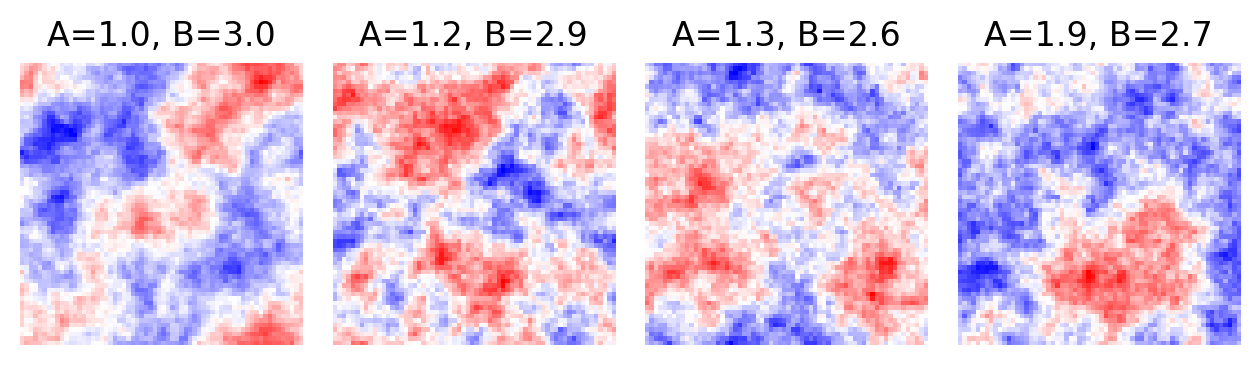

In [4]:
# Model / inference stuff
dataset = np.load(data_dir / f"data.npz")
AB = dataset["true_params"]
lower = np.array([0.1, 2.])
upper = np.array([2., 3.])
parameter_names = ["A", "B"]
# Data
n_pix = 32
n_pix = 64
data_shape = (n_pix, n_pix)
data_dim = np.prod(data_shape)
parameter_dim = len(AB)
# Optimisation

# Load data 
D = dataset["fields"]
D_ = dataset["data"]
Y = dataset["parameters"]

# Add image channels for convolutions
n_use = 5_000
D = D[:n_use, None, ...]
D_ = D_[None, None, ...] # Single batch axis for single measurement
Y = Y[:n_use]

# D, Y = D[:100], Y[:100]

# D = np.stack([D[0]] * 10)
# Y = np.stack([Y[0]] * 10)

print(f"Simulations: {D.shape=} {Y.shape=}, Data {D_.shape}")

D = 2. * (D - D.min()) / (D.max() - D.min()) - 1.

# Plot some training samples for comparison
fig, axs = plt.subplots(1, 4, dpi=200)
for i, ax in enumerate(axs):
    A, B = Y[i]
    ax.set_title(f"{A=:.1f}, {B=:.1f}")
    im = ax.imshow(D[i].squeeze(), cmap="bwr")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "train_samples.png"))
plt.show()

#### Autoencoder 
Fit autoencoder to create embeddings from high-dimensional dataset

In [5]:
# Embedding dimension of autoencoder
z_dim = 32
# Hidden dimension (~number of parameters in autoencoder model)
hidden_dim = 1024 

# Build the autoencoder
autoencoder = AutoEncoderC(
    data_dim=data_shape, 
    z_dim=z_dim, 
    hidden_dim=hidden_dim
)
autoencoder = autoencoder.to(device)

# We use a MSE loss for the reconstruction error
loss_f = lambda _x, x: torch.square(torch.subtract(_x, x)).mean() 

optimizer = torch.optim.Adam(
    autoencoder.parameters(), lr=1e-4, weight_decay=1e-5
)

# batch_size = 1_000
batch_size = 250
D, Y = shuffle(D, Y, random_state=SEED)
validation_prop = 0.2
validation_size = int(D.shape[0] * validation_prop)
assert validation_size > 0 and validation_size < D.shape[0]
x_dataloader_train = get_dataloader_from_arrays(
    D[validation_size:], 
    Y[validation_size:], 
    batch_size=batch_size,
)
x_dataloader_vald = get_dataloader_from_arrays(
    D[:validation_size], 
    Y[:validation_size], 
    batch_size=batch_size,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

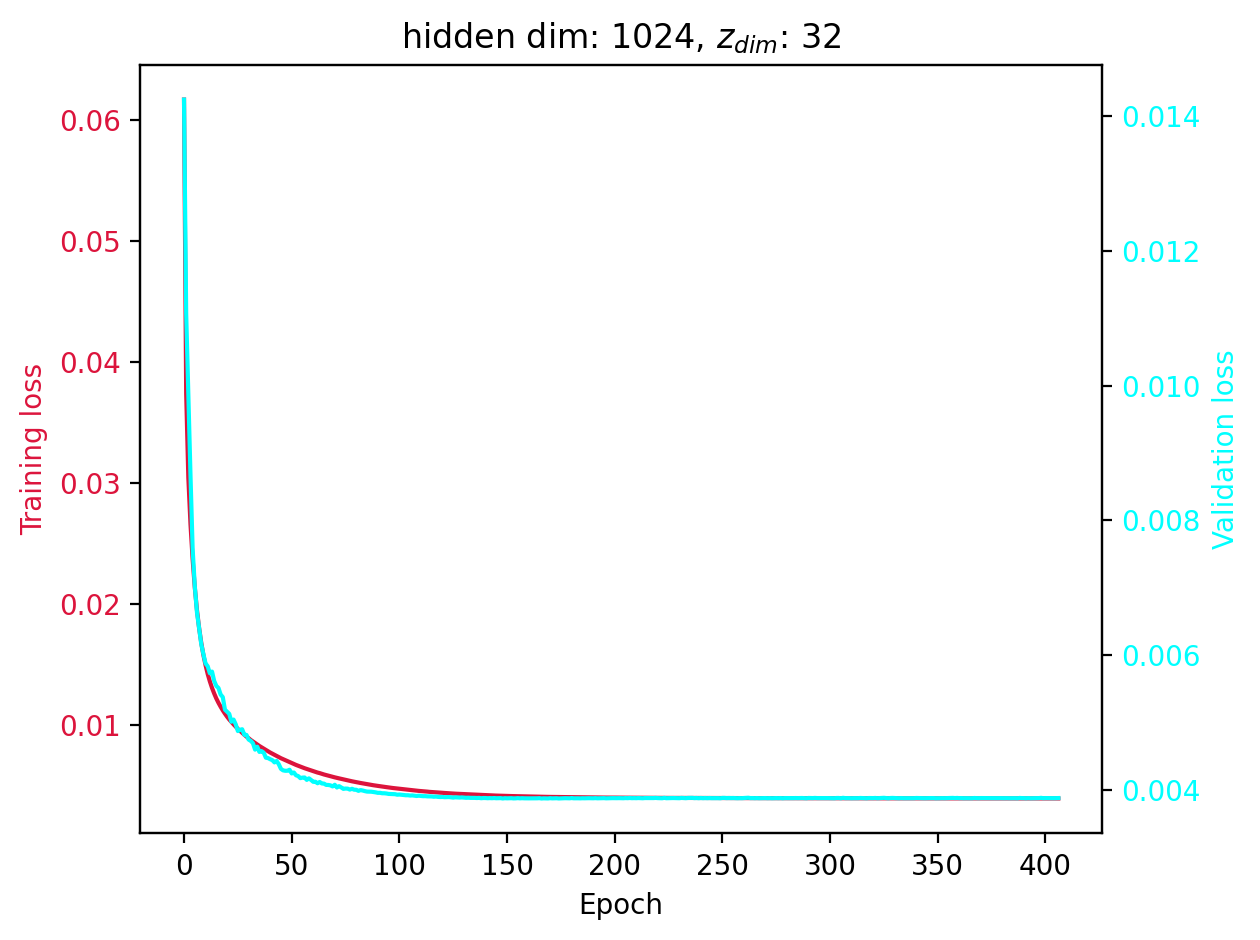

In [6]:
losses_train, losses_vald = list(), list()
early_stopping = 240
n_steps = 1_000
max_iters = n_steps

stop_counter = 0
best_loss_vlad = 1_000_000.
best_state = autoencoder.state_dict()


losses = []
best_vald_idx = 0
with trange(n_steps) as steps:
    # for s, (x, y) in zip(steps, looploader(x_dataloader)):
    for s in steps:
        ## Train
        losses = list()
        autoencoder.train(True)
        for x, _ in x_dataloader_train:
            x = x.to(device)
            # Use autoencoder to return a reconstruction and embedding of input
            _x, emb = autoencoder(x)
            # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
            rec_loss = loss_f(_x, x)

            autoencoder.zero_grad()
            rec_loss.backward()
            optimizer.step()

            losses.append(rec_loss.item())
        loss_train = np.mean(losses)
        losses_train.append(loss_train)
        
        ## Validate
        losses = list()
        autoencoder.eval()
        with torch.no_grad():
            for x, y in x_dataloader_vald:
                x = x.to(device)
                # Use autoencoder to return a reconstruction and embedding of input
                _x, emb = autoencoder(x)
                # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
                rec_loss = loss_f(_x, x)
                losses.append(rec_loss.item())
        loss_vald = np.mean(losses)
        losses_vald.append(loss_vald)
        
        steps.set_postfix(loss=f"{loss_train:.3E}")
        stop_counter += 1
        if loss_vald < best_loss_vlad:
            best_loss_vlad = loss_vald
            best_state = deepcopy(autoencoder.state_dict())
            stop_counter = 0
            best_vald_idx = s
        
        if (s >= max_iters - 1) or stop_counter >= early_stopping:
            break
            

autoencoder.load_state_dict(best_state)
torch.save(autoencoder, data_dir / f"ae_iter_best_weights-{z_dim=}-{hidden_dim=}.pth")
np.savez(
    data_dir / f"EA_history_-{z_dim=}-{hidden_dim=}", 
    loss=np.array(losses_train),
    loss_vald=np.array(losses_vald),
    best_vald_idx=best_vald_idx,
)
# Plot losses as we go
fig, ax1 = plt.subplots(dpi=200)
color = 'crimson'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training loss', color=color)
ax1.plot(losses_train, label="Training loss", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'cyan'
ax2.set_ylabel('Validation loss', color=color)  # we already handled the x-label with ax1
ax2.plot(losses_vald, label="Validation loss", color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"hidden dim: {hidden_dim}, $z_{{dim}}$: {z_dim}")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(figs_dir / f"autoencoder_training_with_vald-{z_dim=}-{hidden_dim=}.png")
plt.show()

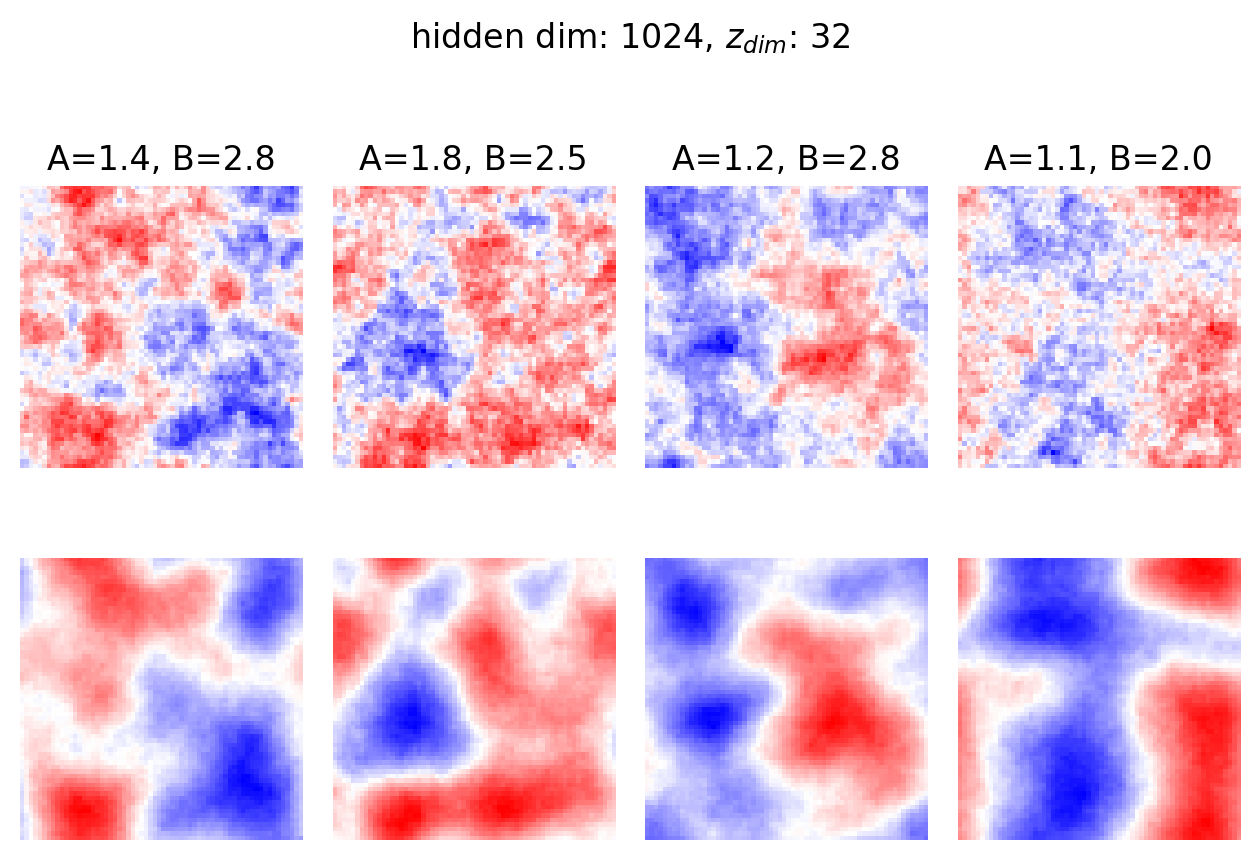

In [7]:
if not isinstance(x, np.ndarray):
    x = x.cpu().detach().numpy()
    _x = _x.cpu().detach().numpy()

# Plot reconstructions against training data
fig, axs = plt.subplots(2, 4, dpi=200)
for i, ax in enumerate(axs[0, :]):
    A, B = y[i]
    ax.set_title(f"{A=:.1f}, {B=:.1f}")
    im = ax.imshow(x[i].reshape(data_shape), cmap="bwr")
    ax.axis("off")
for i, ax in enumerate(axs[1, :]):
    im = ax.imshow(_x[i].reshape(data_shape), cmap="bwr")
    ax.axis("off")

plt.suptitle(f"hidden dim: {hidden_dim}, $z_{{dim}}$: {z_dim}")
plt.tight_layout()
plt.savefig(figs_dir / f"autoencoder_reconstructions-{z_dim=}-{hidden_dim=}.png")

### Sub-question 2

How is ‘new’ data generated with the flow-autoencoder setup

New data is not generated in this setup per se.
The AE projects the data to a loswer dimension, and the flow model learns the distribution of variables in that dimension.

## Questrion 6.4

### Sub-question 1

A posterior is a function of the parameters given a measurement. Create
a grid of points in parameter space to evaluate the posterior on. The
posterior is the product of the likelihood (from the flow or the analytic
solution) and the prior.

We've already solved the analytical solution in the notebook corresponding to question 6.2.

We'll train a flow model to solve the likelihood function. 

Since the parameter space is uniform, the probability for all states is equal ($\large{\frac{1}{|A_{max} - A_{min}| \cdot |B_{max} - B_{min}|}} = \frac{1}{1.9}$), so it can be ignored when calculating the posterior.

#### Normalizing flow
Fit normalizing flow to encoded dataset

The results of the encoders we've trained can be seen here:

![d_z = 8](figs/grfs/autoencoder_reconstructions-z_dim=8-hidden_dim=1024.png)

![d_z = 16](figs/grfs/autoencoder_reconstructions-z_dim=16-hidden_dim=1024.png)

![d_z = 32](figs/grfs/autoencoder_reconstructions-z_dim=32-hidden_dim=1024.png)

The reconstructions of the encoder with $z_{dim}=8$ look too simplistic.

The reconstructions of the encoder with $z_{dim}=16$ look better, but it seems like they're also bad at reconstructing fine details, so we'll use the encoder with $z_{dim}=32$.

In [8]:
hidden_dim, z_dim = 1024, 32
autoencoder = torch.load(data_dir / f"ae_iter_best_weights-{z_dim=}-{hidden_dim=}.pth")

# Turn dropout off
autoencoder.eval()

# # Encode dataset 
# Z = []
# for (x, y) in x_dataloader:
#     x = x.to(device)
#     Z.append(autoencoder.encoder(x))
# Z = torch.cat(Z)

# _, Dz = autoencoder(convert(D).to(device))

DZ = []
for x in D:
    x = convert(x[None]).to(device)
    DZ.append(autoencoder.encoder(x).cpu().detach())
DZ = torch.cat(DZ)
DZ.shape

torch.Size([5000, 32])

In [9]:
# Model
H = 64 # Hidden size
L = 3 # Layers
activation = nn.Tanh 

net_s = lambda: nn.Sequential(
    nn.Linear(z_dim + parameter_dim, H), 
    activation(),
    nn.Linear(H, H), 
    activation(),
    nn.Linear(H, H), 
    activation(),
    nn.Linear(H, z_dim), 
    # activation()
)
net_t = lambda: nn.Sequential(
    nn.Linear(z_dim + parameter_dim, H), 
    activation(), 
    nn.Linear(H, H), 
    activation(), 
    nn.Linear(H, H), 
    activation(), 
    nn.Linear(H, z_dim)
)

# Normalizing flow base distribution
prior = td.MultivariateNormal(
    loc=torch.zeros(z_dim).to(device), 
    covariance_matrix=torch.eye(z_dim).to(device)
)

# Mask arrays for normalizing flow
dim = torch.arange(0, z_dim) % 2
masks = torch.stack(
    [
        dim if i % 2 else dim.flip(dims=(0,))
        for i in range(L)
    ]
).to(device)

flow = RealNVP(net_s, net_t, masks, prior) 
flow = flow.to(device)

  0%|          | 0/100000 [00:00<?, ?it/s]

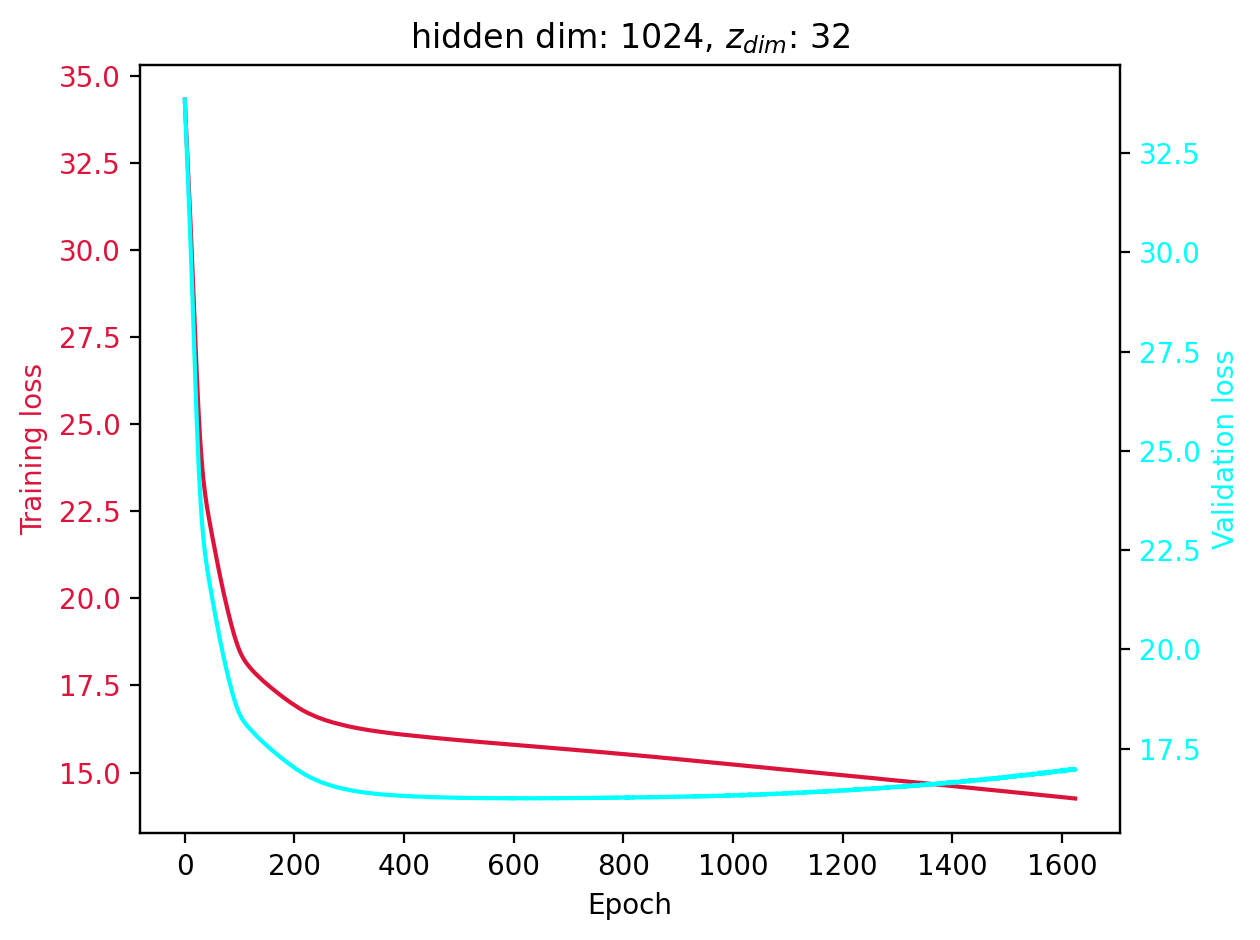

In [10]:
n_sample = 64

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4, weight_decay=1e-5)

batch_size = 1000
# z_dataloader = get_dataloader_from_arrays(Z, Y, batch_size=batch_size)
z_dataloader_train = get_dataloader_from_arrays(
    DZ[validation_size:], 
    Y[validation_size:], 
    batch_size=batch_size,
)
z_dataloader_vald = get_dataloader_from_arrays(
    DZ[:validation_size], 
    Y[:validation_size], 
    batch_size=batch_size,
)

losses_train, losses_vald = list(), list()
early_stopping = 1024
n_steps = 100_000
max_iters = n_steps

stop_counter = 0
best_loss_vlad = 1_000_000.
best_state = autoencoder.state_dict()


losses = []
best_vald_idx = 0
with trange(n_steps) as steps:
    # for s, (x, y) in zip(steps, looploader(z_dataloader)):
    for s in steps:
        ## Train
        losses = list()
        flow.train(True)
        for z, y in z_dataloader_train:
            z, y = z.to(device), y.to(device)
            loss = -flow.log_prob(z, y).mean()
        
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.item())
        loss_train = np.mean(losses)
        losses_train.append(loss_train)
        
        ## Validate
        losses = list()
        flow.eval()
        with torch.no_grad():
            for z, y in z_dataloader_vald:
                z, y = z.to(device), y.to(device)
                loss = -flow.log_prob(z, y).mean()
                losses.append(loss.item())
        loss_vald = np.mean(losses)
        losses_vald.append(loss_vald)
        
        steps.set_postfix(loss=f"{loss_train:.3E}")
        stop_counter += 1
        if loss_vald < best_loss_vlad:
            best_loss_vlad = loss_vald
            best_state = deepcopy(flow.state_dict())
            stop_counter = 0
            best_vald_idx = s
        
        if (s >= max_iters - 1) or stop_counter >= early_stopping:
            break
        
        
        
        
        ############
        """
        x, y = x.to(device), y.to(device)

        loss = -flow.log_prob(x, y).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        steps.set_postfix(loss=f"{loss:.3E}")

        if s % 500 == 0:
            # Hold some training data to plot with samples
            x = autoencoder.decoder(x[:4]).cpu().detach().numpy()
            
            # Sample some parameters from the training set
            parameters = Y[np.random.randint(0, len(Y), size=(n_sample,))]
            parameters = convert(parameters).to(device)

            # Sample from the flow conditioned on these parameters
            samples = flow.sample(n_sample, parameters)
            samples = autoencoder.decoder(samples) 
            samples = samples.cpu().detach().numpy()

            # Plot reconstructions against training data
            fig, axs = plt.subplots(2, 4, dpi=200)
            for i, ax in enumerate(axs[0, :]):
                A, B = Y[i]
                ax.set_title(f"{A=:.1f}, {B=:.1f}")
                im = ax.imshow(x[i].reshape(data_shape), cmap="bwr")
                ax.axis("off")
            for i, ax in enumerate(axs[1, :]):
                im = ax.imshow(samples[i].reshape(data_shape), cmap="bwr")
                ax.axis("off")
            plt.tight_layout()
            plt.savefig(os.path.join(figs_dir, "flow_samples.png"))
            plt.close()

            # Plot losses as we go
            plt.figure()
            plt.plot(losses)
            plt.savefig(os.path.join(figs_dir, "loss_nvp_field.png"))
            plt.close()
        """
        

flow.load_state_dict(best_state)
torch.save(flow, data_dir / f"flow_AE_iter_best_weights-ae_{z_dim=}-ae_{hidden_dim=}.pth")
np.savez(
    data_dir / f"flow_EA_history_-{z_dim=}-{hidden_dim=}", 
    loss=np.array(losses_train),
    loss_vald=np.array(losses_vald),
    best_vald_idx=best_vald_idx,
)
# Plot losses as we go
fig, ax1 = plt.subplots(dpi=200)
color = 'crimson'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training loss', color=color)
ax1.plot(losses_train, label="Training loss", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'cyan'
ax2.set_ylabel('Validation loss', color=color)  # we already handled the x-label with ax1
ax2.plot(losses_vald, label="Validation loss", color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"hidden dim: {hidden_dim}, $z_{{dim}}$: {z_dim}")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(figs_dir / f"flow_AE_training_with_vald-{z_dim=}-{hidden_dim=}.png")
plt.show()

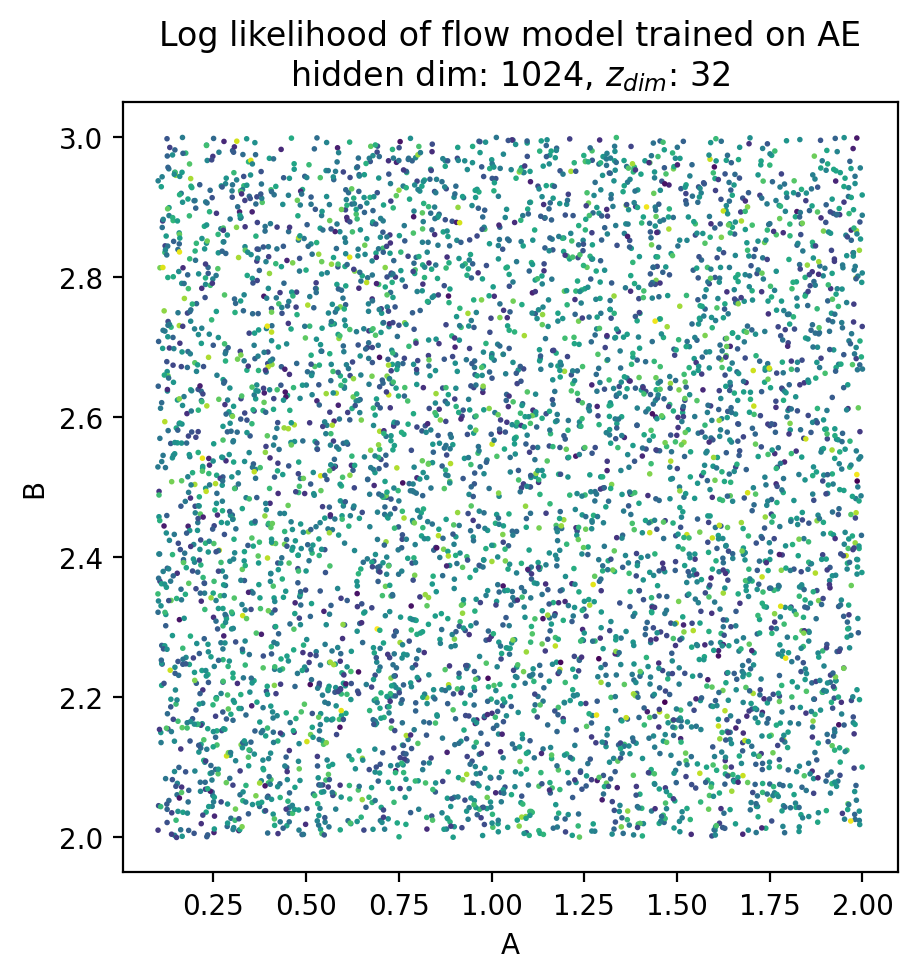

In [11]:
"""
    Map likelihood of flow in parameter space
    - encode data
"""
# Encode dataset 
Lxy = []
for ds in [z_dataloader_train, z_dataloader_vald]:
    for z, y in ds:
        z, y = z.to(device), y.to(device)
        # z = autoencoder.encoder(x)
        res = flow.log_prob(z, y).cpu().detach()
        Lxy.append(res)
Lxy = torch.cat(Lxy).numpy()

plt.figure(dpi=200, figsize=(5., 5.))
points = Y[:Lxy.size].T
if not isinstance(points, np.ndarray):
    points = points.cpu().detach().numpy()
plt.scatter(*points, c=Lxy, s=1.)
plt.xlabel("A")
plt.ylabel("B")
plt.title(f"Log likelihood of flow model trained on AE\nhidden dim: {hidden_dim}, $z_{{dim}}$: {z_dim}")
plt.savefig(figs_dir / f"Lx_flow_with_AE-{z_dim=}-{hidden_dim=}.png")
plt.show()

In [12]:
"""
    Plot likelihood in parameter space
"""
# Uniform prior has this value inside the prior
prior_log_prob = np.log(1. / np.prod(upper - lower))

# Grid of parameter points in parameter space
X_, Y_ = np.mgrid[lower[0]:upper[0]:100j, lower[1]:upper[1]:100j]
Y = torch.as_tensor(np.vstack([X_.ravel(), Y_.ravel()])).float().T.to(device)
# Map data to an encoding
# z_ = autoencoder.encoder(D_.to(device))
z_ = autoencoder.encoder(convert(D_).to(device))

# Load pairs of data (repeated) with each parameter point 
# inference_dataloader = DataLoader(
inference_dataloader = get_dataloader_from_arrays(
    torch.tile(z_, (len(Y), 1)), 
    Y, 
    batch_size=1
)
Lxy = np.zeros((len(Y),))
for z, y in tqdm(inference_dataloader):
    z, y = z.to(device), y.to(device)
    # z = autoencoder.encoder(x).to(device)
    # Lxy[i] = flow.log_prob(z_, y).cpu().detach().numpy() + prior_log_prob
    Lxy[i] = flow.log_prob(z, y).cpu().detach().numpy() + prior_log_prob

100%|██████████| 10000/10000 [00:13<00:00, 758.47it/s]


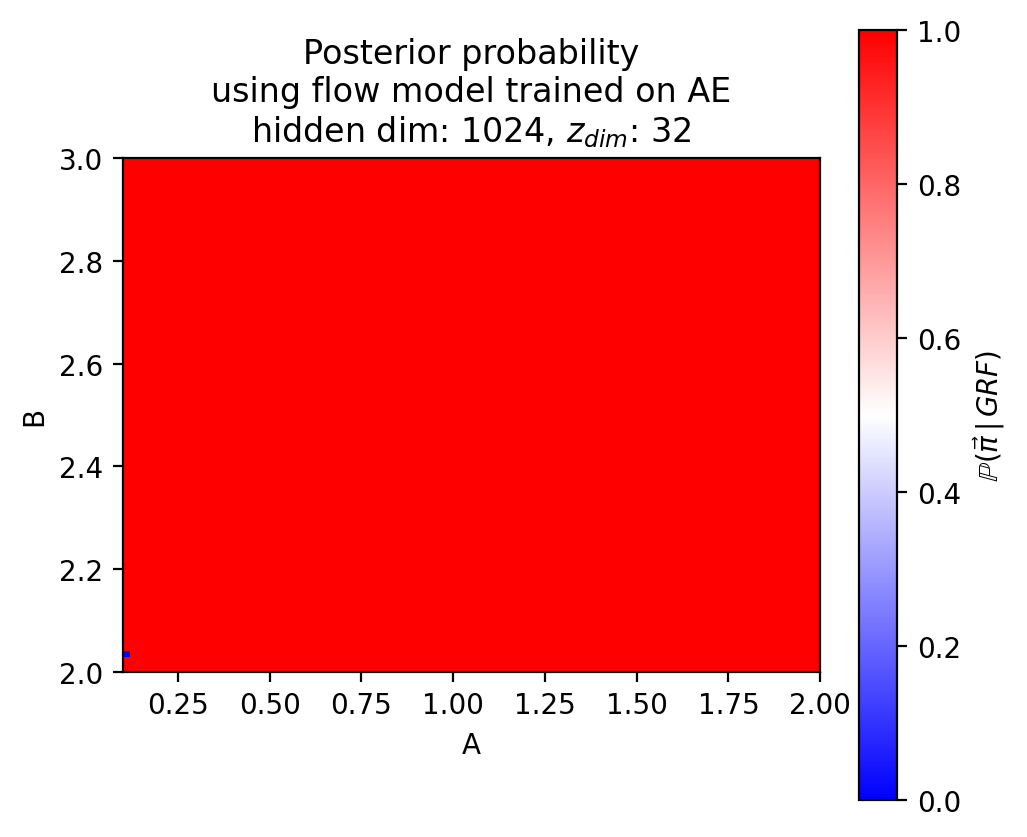

In [13]:
plt.figure(dpi=200, figsize=(5., 5.))
# plt.scatter(*(Y.cpu().detach().numpy()).T, c=Lxy, alpha=0.4)
plt.imshow(
    np.exp(Lxy).reshape(100, 100).T, 
    origin="lower", 
    cmap="bwr", 
    extent=[lower[0], upper[0], lower[1], upper[1]],
    aspect=1.4,
)
plt.xlabel("A")
plt.ylabel("B")
plt.title(f"Posterior probability\n" \
          f"using flow model trained on AE\nhidden dim: {hidden_dim}, $z_{{dim}}$: {z_dim}")
plt.savefig(figs_dir / f"LLH_flow_with_AE_for_AB_grid-{z_dim=}-{hidden_dim=}.png")
plt.colorbar(
    label=r"$\mathbb{{P}}(\vec\pi\,|\,GRF)$",
    fraction=0.05,
)
plt.show()

Both when using the analytical prior (in `generate_grfs_labwork.ipynb`) and when using the flow over the encoded data, the results seem to not match our expectations.

The flow network was tested with several encoding sizes, but all results were similar.

The code should be examined to make sure there are no bugs (especially the analytical likelihood evaluation method), and the training loop should be repeated with variations.